In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

# Configurations

In [2]:
output_dir = '/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir = os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir = '/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'
stim_classes = ['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list = ['V1', 'V2', 'V3']
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1, 9)]
subj = 'subj02'
roi = 'V1'
voxels = 'pRFcenter'
stim_class = 'forward-spiral'

# Eccentricity bin information
e1, e2 = 0.5, 4
enum = 7
enum_range = range(7) if enum == 7 else range(3)
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels) + 1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Figure settings
utils.set_rcParams({'figure.dpi': 72*2})
sns.set_context("notebook", font_scale=2)

# Load in data

In [29]:
datapoints_df = pd.DataFrame({})
for subj in subj_list:
    subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', f'e1-0.5_e2-4_nbin-7_sub-{subj}_roi-V1_vs-pRFcenter.csv'))
    datapoints_df = pd.concat((datapoints_df, subj_df), axis=0)



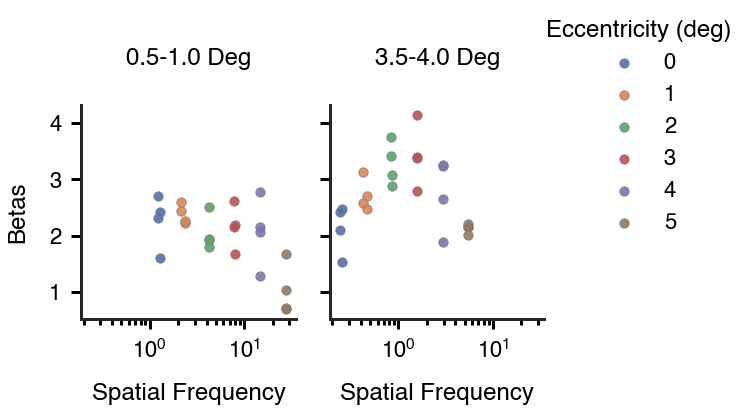

In [33]:
bins_to_plot = [bin_labels[0], bin_labels[-1]]
vis1D.plot_datapoints(datapoints_df.query('sub == "subj01"'),
                      'local_sf', 'betas', hue='freq_lvl', 
                      col='ecc_bin', col_order=bins_to_plot, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=None)

## Load in loss

In [3]:
args = ['class', 'lr', 'eph', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, roi, subj, stim_class in itertools.product(enum_range, roi_list, subj_list, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    loss_file_name = f'loss-history_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', 'corrected', loss_file_name))

cur_loss_df = pd.DataFrame({})
for l_file in l:
    tmp_df = utils.load_dataframes([l_file], *args)
    tmp_df = tmp_df.query('epoch == @max_epoch-1')
    cur_loss_df = pd.concat((cur_loss_df, tmp_df), axis=0)

In [4]:
args = ['class', 'lr', 'eph', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, roi, subj, stim_class in itertools.product(enum_range, roi_list, subj_list, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    loss_file_name = f'loss-history_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', 'uncorrected', loss_file_name))

old_loss_df = pd.DataFrame({})
for l_file in l:
    tmp_df = utils.load_dataframes([l_file], *args)
    tmp_df = tmp_df.query('epoch == @max_epoch-1')
    old_loss_df = pd.concat((old_loss_df, tmp_df), axis=0)

In [5]:
cur_loss_df['df_type'] = 'corrected'
old_loss_df['df_type'] = 'uncorrected'
loss_df = pd.concat((cur_loss_df, old_loss_df), axis=0)


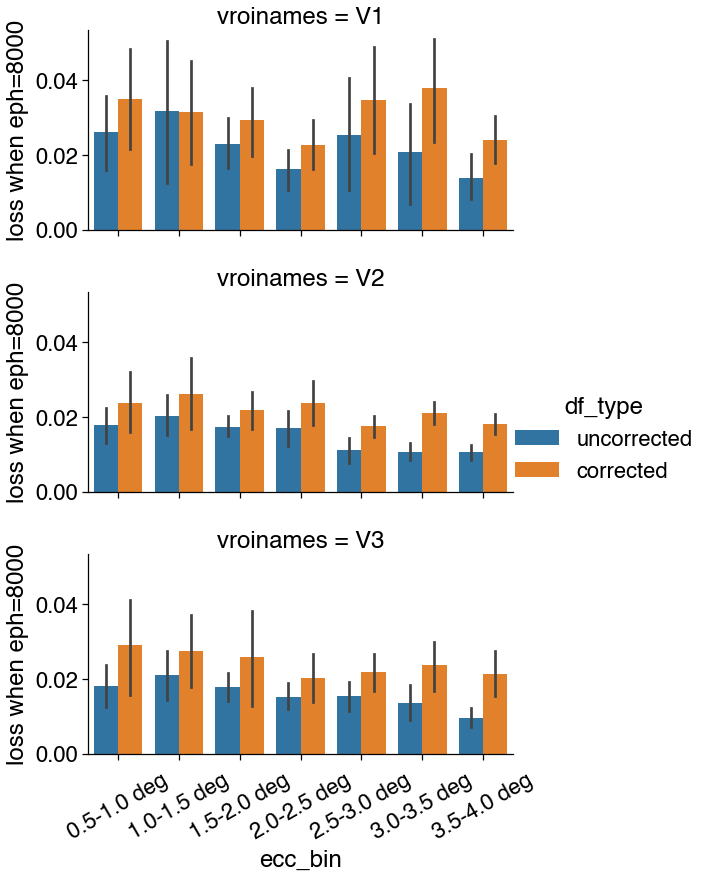

In [12]:
sns.set_context("notebook", font_scale=2)
subj_list_tmp = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']
g = sns.catplot(data=loss_df.query('sub in @subj_list_tmp'), order=bin_labels,
                sharey=True, row='vroinames', 
                hue='df_type', hue_order=['uncorrected', 'corrected'], 
                x='ecc_bin',y='loss', errorbar=('ci', 68),
                kind='bar', height=utils.get_height_based_on_width(6,1.5), aspect=2)
g.set_xticklabels(rotation=30)
g.set_ylabels('loss when eph=8000')
plt.savefig('/Volumes/server/Projects/sfp_nsd/derivatives/figures/tmp/loss_comparison.png', bbox_inches='tight')